In [1]:
import numpy as np
import scipy
from scipy import signal
import matplotlib.pyplot as plt
from math import pi, isinf
from scipy.interpolate import interp1d
from scipy.misc import derivative
from scipy.optimize import curve_fit
from scipy.integrate import quad

import matplotlib.cm as cm

In [2]:
%matplotlib inline

In [29]:
font = {'family': 'serif', 'size': 14}
plt.rc('font', **font)
plt.rc('text', usetex=True)

In [4]:
cmap = plt.get_cmap("tab10")

# system info

In [5]:
T_list = [20, 40, 60, 80, 100]
kb_in_kcalmol = 1.987204259*10**-3
#kbT = (TT+273.15) * kb_in_kcalmol #kcal/mol

mu_dict={20:[-10.9425, 0.144646],
        40: [-11.0777, 0.127142],
        60: [-11.2246, 0.127939],
        80: [-11.3008, 0.122396],
        100: [-11.2422, 0.120769]}

#mu_absorption = mu_dict[CT] #kcal/mol

In [6]:
avogadro = 6.0221408e+23
a3_to_L = 10e-27
inva3_to_molperL = 1e27/avogadro

In [7]:
ref_v0 = 0.00001

In [8]:
inva3_to_molperL

1660.5390561442869

In [9]:
c_dict = {}

for TT in T_list:
    
    c_dict[TT] = {}

    # name N_para N_water V[A^3] V_error[A^3] c_para[1/A^3] c_para_error
    c_list = np.genfromtxt('./molarc-'+str(TT)+'C.dat', str)[:,:]
    
    for a in c_list:
        c_dict[TT][a[0]] = {'c': float(a[5]), 
                        'n_p': int(a[1]), 
                        'n_w': int(a[2])}

### define functions for the S0 method

In [10]:
from S0functions import *

# Read in the values of S(k) at different k

In [11]:
Sk={}

In [12]:
for s in T_list:
    Sk[s] = {}
    
    for nn in [n for n in c_dict[s].keys()]:
        print(nn)
        Sk[s][nn] = {}
        for ii in ['CC', 'CO','OO']:
            Sk[s][nn][ii] = np.loadtxt(nn+"/Sk-"+ii+"-real-avg.list", skiprows=0)[:,:]

box16-43-100-4x4x4-20C
box17-30-100-4x4x4-20C
box20-72-100-4x4x4-20C
box22-135-100-3x3x3-20C
box22-135-100-4x4x4-20C
box24-188-100-3x3x3-20C
box24-188-100-4x4x4-20C
box24-90-100-4x4x4-20C
box28-268-100-3x3x3-20C
box28-302-80-3x3x3-20C
box30-10-2x2x2-20C
box30-10-3x3x3-20C
box30-15-2x2x2-20C
box30-20-2x2x2-20C
box30-20-3x3x3-20C
box30-30-2x2x2-20C
box30-40-2x2x2-20C
box30-40-3x3x3-20C
box30-50-2x2x2-20C
box30-60-2x2x2-20C
box30-60-3x3x3-20C
box30-70-2x2x2-20C
box30-80-2x2x2-20C
box30-80-3x3x3-20C
box34-401-400-3x3x3-20C
box35-100-2x2x2-20C
box35-100-3x3x3-20C
box35-110-2x2x2-20C
box35-120-2x2x2-20C
box35-120-3x3x3-20C
box35-135-2x2x2-20C
box35-135-3x3x3-20C
box35-90-2x2x2-20C
box36-607-80-3x3x3-20C
box50-10-1x1x1-20C
box50-10-2x2x2-20C
box50-1-1x1x1-20C
box50-1-2x2x2-20C
box16-43-100-4x4x4-40C
box17-30-100-4x4x4-40C
box20-72-100-4x4x4-40C
box22-135-100-3x3x3-40C
box22-135-100-4x4x4-40C
box24-188-100-3x3x3-40C
box24-188-100-4x4x4-40C
box24-90-100-4x4x4-40C
box28-268-100-3x3x3-40C
box28-3

In [13]:
S0_dict = {}

kcut = 0.004

for s in T_list: 
    S0_dict[s] = {}
    
    for nn in [n for n in c_dict[s].keys()]:
        S0_dict[s][nn] = {}
        S0_dict[s][nn].update(c_dict[s][nn])
        
        try:

            for ii in ['CC', 'CO','OO']:


                Sk_cut = np.asarray([sk for sk in Sk[s][nn][ii][1:] if sk[0]**2.+sk[1]**2.+sk[2]**2. < kcut ])
                                     #and not np.isnan(sk[5])])
                #print(Sk_cut)
                ksqr_now = [ sk[0]**2.+sk[1]**2.+sk[2]**2. for sk in Sk_cut]
                sk_now = Sk_cut[:,3] 
                sk_error_now = Sk_cut[:,5]

                #if np.isnan(Sk[ii][nn][2,3]): continue
                popt, pcov = curve_fit(fit_OrnsteinZernike, 
                                   ksqr_now, 
                                   sk_now, )
                                   #sigma=sk_error_now,
                                   #absolute_sigma=False) #,
                                   # bounds=((-np.inf,  0), (np.inf, np.inf)))
                perr = np.sqrt(np.diag(pcov))
                #print(ii, nn,popt,perr)
                if isinf(perr[0]): popt = [float('nan'), float('nan')]
                #print(ii, frac,popt,perr)

                S0_dict[s][nn][ii]={'S0': popt[0], 
                                    'S0_error': perr[0],
                                    'value': popt, 
                                    'error': perr}
        except:
            print(s, nn, ii)
            del S0_dict[s][nn]
            

/Users/tc/miniconda/envs/chicken/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


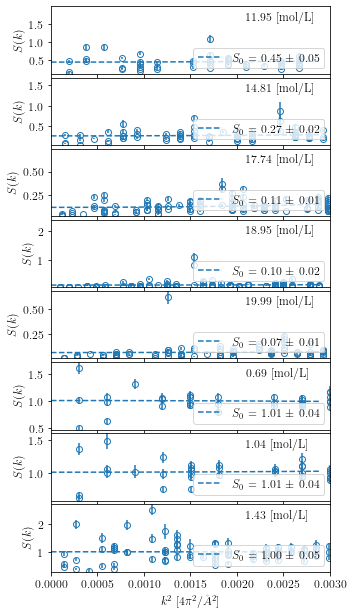

In [14]:
fig, ax = plt.subplots(8,1, sharex=True, sharey=False,figsize=(5,6.5*1.6))

krange = 0.0001*np.arange(30)

s = 80
ii = 'CC'

for i,nn in enumerate([n for n in c_dict[s].keys()][::2][:8]):
    
    sk_now = Sk[s][nn][ii][1:]
    
    ksqr_now = [ sk[0]**2.+sk[1]**2.+sk[2]**2. for sk in sk_now]
    sk_v_now = sk_now[:,3]
    sk_error_now = sk_now[:,5]
    popt = S0_dict[s][nn][ii]['value']
    perr = S0_dict[s][nn][ii]['error']
    c_now = S0_dict[s][nn]['c']
    
    ax[i].errorbar(ksqr_now, sk_v_now, sk_error_now,
             ls='',marker='o', c=cmap(0),
                   markerfacecolor='None')
    ax[i].plot(krange, fit_OrnsteinZernike(krange, *popt), '--',  c=cmap(0),
         label='$S_0~$=%5.2f $\pm$ %5.2f' % (popt[0],perr[0]))
    
    ax[i].text(0.7, 0.75, '%5.2f [mol/L]' % (c_now*inva3_to_molperL),
                 fontsize=12, transform=ax[i].transAxes,
                      verticalalignment='bottom')
    ax[i].legend(loc='lower right')
    ax[i].set_xlim([0,0.003])
    #ax[i].set_ylim([0.6,1.5])
    ax[i].margins(-0.0, x=None, y=None, tight=True)
    ax[i].set_ylabel(r"$S(k)$")
    
ax[-1].set_xlabel("$k^2$ [$4\pi^2$/$\AA^2$]")    
#ax[0].set_ylabel("$\lambda$")
fig.subplots_adjust(hspace=0.05, wspace=0.02)
#fig.tight_layout()

#fig.savefig("selected-k-S-mof5-co2.pdf", dpi=300, bbox_inches='tight')

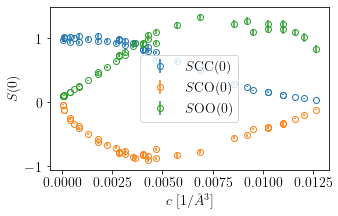

In [31]:
fig, ax = plt.subplots(figsize=(5,3))

for i,ii in enumerate(['CC', 'CO','OO']):
    slist_now = np.array([[ v['c'],v[ii]['S0'],v[ii]['S0_error']] for v in S0_dict[s].values()])
    ax.errorbar(slist_now[:,0],slist_now[:,1], slist_now[:,2],
           ls='',marker='o',markerfacecolor='None', c=cmap(i),
           label="$S$"+ii+"(0)")

ax.legend()
ax.set_ylabel("$S(0)$")
    
ax.set_xlabel("$c~[1/\AA^3]$")  

fig.savefig("S-plot.pdf", dpi=300, bbox_inches='tight')

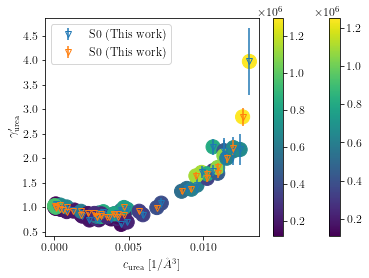

In [16]:
fig, ax = plt.subplots(figsize=(6,4))

s=20
# $0:ca $1:c_ratio $2:SAA $3:SAA_error $4:SAB $5:SAB_error
slist_now = np.array([[ v['c'], v['n_p']/v['n_w'], \
                       v['CC']['S0'],v['CC']['S0_error'], \
                       v['CO']['S0'],v['CO']['S0_error'],
                      v['n_p']/v['c']] \
                      for v in S0_dict[s].values()])

ac = ax.scatter(slist_now[:,0], get_activity_coefficient(slist_now[:,2], slist_now[:,4], slist_now[:,1]),
          c=slist_now[:,6],s=200)

plt.colorbar(ac)

ax.errorbar(slist_now[:,0],
        get_activity_coefficient(slist_now[:,2], slist_now[:,4], slist_now[:,1]),
            get_activity_coefficient(slist_now[:,2]+slist_now[:,3], slist_now[:,4]-slist_now[:,5], slist_now[:,1])
            -get_activity_coefficient(slist_now[:,2], slist_now[:,4], slist_now[:,1]),
            ls='',
            marker='v',markerfacecolor='None',
           label='S0 (This work)')

s=80
# $0:ca $1:c_ratio $2:SAA $3:SAA_error $4:SAB $5:SAB_error
slist_now = np.array([[ v['c'], v['n_p']/v['n_w'], \
                       v['CC']['S0'],v['CC']['S0_error'], \
                       v['CO']['S0'],v['CO']['S0_error'],
                      v['n_p']/v['c']] \
                      for v in S0_dict[s].values()])

ac = ax.scatter(slist_now[:,0], get_activity_coefficient(slist_now[:,2], slist_now[:,4], slist_now[:,1]),
          c=slist_now[:,6],s=200)

plt.colorbar(ac)

ax.errorbar(slist_now[:,0],
        get_activity_coefficient(slist_now[:,2], slist_now[:,4], slist_now[:,1]),
            get_activity_coefficient(slist_now[:,2]+slist_now[:,3], slist_now[:,4]-slist_now[:,5], slist_now[:,1])
            -get_activity_coefficient(slist_now[:,2], slist_now[:,4], slist_now[:,1]),
            ls='',
            marker='v',markerfacecolor='None',
           label='S0 (This work)')


ax.set_ylabel("$\gamma'_\mathrm{urea}$")
    
ax.set_xlabel('$c_\mathrm{urea}~[1/\AA^3]$')  
#ax.set_xticks(np.arange(2, 8.1, step=2))
ax.legend()

#fig.savefig("dilute-gamma-ca-"+sysname+".pdf", dpi=300, bbox_inches='tight')

/Users/tc/IST-Cheng Dropbox/Bingqing Cheng/solubility/urea-water/md-charmm/S0functions.py:33: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  mu_now = kbT*quad(int_func, np.log(c0), a)[0]
/Users/tc/IST-Cheng Dropbox/Bingqing Cheng/solubility/urea-water/md-charmm/S0functions.py:37: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 

Text(0.5, 0, '$c_\\mathrm{urea}$ [mol/L]')

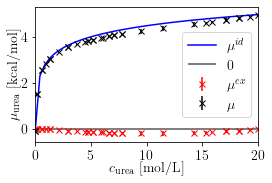

In [30]:
# compute mu^ex_ion using Gibbs-Duhem
s=80
kbT = (float(s)+273.15) * kb_in_kcalmol

ca_now = np.array([ v['c'] for v in S0_dict[s].values()])

xa_now = np.array([ v['n_p']/(v['n_p']+v['n_w']) for v in S0_dict[s].values()])
xb_now = 1- xa_now

ca_ratio_now = np.array([ v['n_p']/v['n_w'] for v in S0_dict[s].values()])
cb_ratio_now = 1/ca_ratio_now

saa_now = np.array([ [v['CC']['S0'],v['CC']['S0_error']] for v in S0_dict[s].values()])
sab_now = np.array([ [v['CO']['S0'],v['CO']['S0_error']] for v in S0_dict[s].values()])
sbb_now = np.array([ [v['OO']['S0'],v['OO']['S0_error']] for v in S0_dict[s].values()])

fig, ax = plt.subplots(figsize=(4,2.5))
"""
mu_p = mu_x_GH(saa_now,sab_now,sbb_now,xa_now,0.1,kbT)
ax.errorbar(ca_now*inva3_to_molperL,
            mu_p[:,1]-ideal_mu(ca_now, ca_now[0], kbT),
            yerr=mu_p[:,2], 
            marker='x',markerfacecolor='None',ls='',
            c='k', label='$\mu^{ex}$ (GH)')

ax.errorbar(ca_now*inva3_to_molperL,
            mu_p[:,1],
            yerr=mu_p[:,2], 
            marker='o',markerfacecolor='None',ls='',
            c='k', label='$\mu$')
"""

mu_p = excess_mu(ca_now,saa_now,sab_now,ca_ratio_now,ref_v0,kbT)

ax.errorbar(ca_now*inva3_to_molperL,
            mu_p[:,1],
            yerr=mu_p[:,2], 
            marker='x',markerfacecolor='None',ls='',
            c='r', label='$\mu^{ex}$')

ax.errorbar(ca_now*inva3_to_molperL,
            mu_p[:,1] + ideal_mu(ca_now, ref_v0, kbT),
            yerr=mu_p[:,2], 
            marker='x',markerfacecolor='None',ls='',
            c='k', label='$\mu$')

ca_plotrange = np.linspace(np.amin(ca_now), np.amax(ca_now))
ax.plot(ca_plotrange*inva3_to_molperL, ideal_mu(ca_plotrange, ref_v0, kbT), 
        'blue',
        label='$\mu^{id}$')

ax.hlines(y=0, xmin=0, xmax=20, ls='-', linewidth=2, 
          color='gray', label='0')

ax.legend()

ax.set_xlim([0,20])
ax.set_ylabel("$\mu_\mathrm{urea}$ [kcal/mol]",labelpad=0)  
ax.set_xlabel("$c_\mathrm{urea}$ [mol/L]",labelpad=0) 

In [18]:
for s in T_list:
    # compute mu^ex_ion using Gibbs-Duhem
    kbT = (float(s)+273.15) * kb_in_kcalmol

    ca_now = np.array([ v['c'] for v in S0_dict[s].values()])

    xa_now = np.array([ v['n_p']/(v['n_p']+v['n_w']) for v in S0_dict[s].values()])
    xb_now = 1- xa_now

    ca_ratio_now = np.array([ v['n_p']/v['n_w'] for v in S0_dict[s].values()])
    cb_ratio_now = 1/ca_ratio_now

    saa_now = np.array([ [v['CC']['S0'],v['CC']['S0_error']] for v in S0_dict[s].values()])
    sab_now = np.array([ [v['CO']['S0'],v['CO']['S0_error']] for v in S0_dict[s].values()])
    sbb_now = np.array([ [v['OO']['S0'],v['OO']['S0_error']] for v in S0_dict[s].values()])

    mu_ex = excess_mu(ca_now,saa_now,sab_now,ca_ratio_now,ref_v0,kbT)
    print(mu_ex[::5])

    np.savetxt('mu-ex-T-'+str(s)+'.dat', mu_ex)

/Users/tc/IST-Cheng Dropbox/Bingqing Cheng/solubility/urea-water/md-charmm/S0functions.py:33: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  mu_now = kbT*quad(int_func, np.log(c0), a)[0]
/Users/tc/IST-Cheng Dropbox/Bingqing Cheng/solubility/urea-water/md-charmm/S0functions.py:37: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 

[[ 7.19423000e-03 -1.56097247e-01  1.56963610e-01]
 [ 1.14175000e-02 -2.24507220e-02  8.81859349e-02]
 [ 4.17528000e-04  4.48735451e-02  2.62091016e-02]
 [ 1.33664000e-03  1.01255816e-02  2.81989737e-02]
 [ 2.98728000e-03 -7.22670947e-02  2.85557317e-02]
 [ 3.29530000e-03 -8.24126324e-02  2.60633933e-02]
 [ 4.89673000e-03 -1.25302639e-01  2.55254170e-02]
 [ 8.86735000e-05  5.29966205e-02  8.11678520e-03]]
[[ 7.09727000e-03 -2.80993824e-01  1.39095630e-01]
 [ 1.12773000e-02 -1.70382162e-01  7.45345778e-02]
 [ 4.11510000e-04 -7.10778804e-02  2.25114158e-02]
 [ 1.31739000e-03 -1.05712874e-01  2.46037781e-02]
 [ 2.94468000e-03 -1.91350677e-01  2.53322082e-02]
 [ 3.24837000e-03 -2.04266494e-01  2.31361933e-02]
 [ 4.82767000e-03 -2.56812018e-01  2.28775454e-02]
 [ 8.74237000e-05 -5.08678460e-02  6.05361626e-03]]
[[ 6.99878000e-03 -2.91226741e-01  1.47787751e-01]
 [ 1.11368000e-02 -1.75267090e-01  7.61190453e-02]
 [ 4.04882000e-04 -5.36458576e-02  2.69451084e-02]
 [ 1.29671000e-03 -1.05630060

In [19]:
dmu_fep_list = np.genfromtxt('../ti-box16-soft-l20-bar-'+str(s)+'C/dmu.dat',str)
dmu_fep = np.array([ [int(s[3]), float(s[4]), float(s[5])] for s in dmu_fep_list])

In [20]:
sum_dmu_fep = 0 * dmu_fep

for i, dd in enumerate(dmu_fep):
    sum_dmu_fep[i, 0] = dd[0]/dmu_fep[-1,0]
    sum_dmu_fep[i, 1] = dd[1]
    sum_dmu_fep[i, 2] = dd[2]
    if i >= 1: 
        sum_dmu_fep[i, 1] += sum_dmu_fep[i-1, 1]
        sum_dmu_fep[i, 2] += sum_dmu_fep[i-1, 2]

No handles with labels found to put in legend.


Text(0.5, 0.1, '100 C')

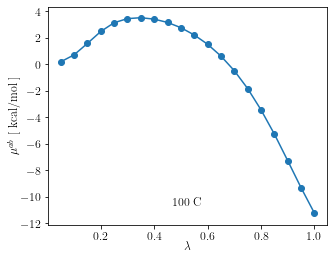

In [21]:
fig, ax = plt.subplots(figsize=(5,4))

ax.errorbar(sum_dmu_fep[:,0], sum_dmu_fep[:,1], yerr=sum_dmu_fep[:,2]
        ,marker='o')

#ax.plot(l_mu[:,0], 0*l_mu[:,1],
#         c='k',lw=0.2, ls='-')

ax.set_xlabel("$\lambda$", labelpad=0) 
ax.set_ylabel("$\mu^{ab}$ [ kcal/mol ]", labelpad=0) 

ax.legend(loc='upper right',ncol=1,frameon=False,fontsize=10.5,handletextpad=0.1)

ax.text(0.5, 0.1, str(s)+" C",
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes)

#fig.savefig("MOF5-co2-mu_ab-"+NN+"-218K.pdf", dpi=300, bbox_inches='tight')